In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics.regression import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
import matplotlib.pyplot as plt

In [29]:
data=pd.read_csv('winequality-white.csv')
data.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6
1,6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...
2,8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...
3,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...
4,7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...


In [30]:
data=pd.read_csv('winequality-white.csv',sep=';')#分隔符比较奇怪，要自己设置
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [31]:
data['quality'].value_counts()#可知品质分布在3-9之间

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [32]:
from collections import Counter
print(Counter(data['quality']))#分布不均衡需要SMOTE

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})


In [33]:
data.info()#4898个样本,还算多，但对于神经网络还不够友好

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [34]:
from imblearn.over_sampling import SMOTE # 过抽样处理库SMOTE
from imblearn.under_sampling import RandomUnderSampler # 欠抽样处理库RandomUnderSampler
from imblearn.ensemble import EasyEnsemble # 简单集成方法EasyEnsemble

In [35]:
Y=data['quality']
X=data.drop('quality', axis=1)#将X、Y取好

In [36]:
groupby_data_orgianl = data.groupby('quality').count() # 对label做分类汇总
print (groupby_data_orgianl) # 打印输出原始数据集样本分类分布

         fixed acidity  volatile acidity  citric acid  residual sugar  \
quality                                                                 
3                   20                20           20              20   
4                  163               163          163             163   
5                 1457              1457         1457            1457   
6                 2198              2198         2198            2198   
7                  880               880          880             880   
8                  175               175          175             175   
9                    5                 5            5               5   

         chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
quality                                                                        
3               20                   20                    20       20    20   
4              163                  163                   163      163   163   
5             1457    

In [37]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42,k_neighbors=3)#建立somte模型,42 for seed,k近邻调成3，神坑，连默认值都不到……

In [38]:
X_smo, Y_smo =smo.fit_sample(X, Y)#获得分割后的数据

In [39]:
#以下是未使用SMOTE进行的预测

In [40]:
X_TRAIN,X_TEST,Y_TRAIN,Y_TEST=train_test_split(X,Y,test_size=0.3)#分割

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_TRAIN)
X_TEST_scaled = scaler.transform(X_TEST)#标准化

In [42]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_scaled.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

    optimizer = tf.compat.v1.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model#写个model函数待会训练用

In [43]:
model = build_model()

In [44]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)#用一下earlystop防止过拟合

In [45]:
result=model.fit(X_scaled,Y_TRAIN, epochs=5,validation_split=0.2, verbose=0,callbacks=[early_stop])

In [46]:
model.evaluate(X_TEST_scaled,Y_TEST)#评估一下，貌似还行，loss有点惨不忍睹……

1470/1470 [==============================] - 0s 141us/sample - loss: 0.7417 - mae: 0.6676


[0.7416644475087016, 0.6675554]

In [47]:
pre=model.predict(X_TEST_scaled)

In [48]:
from sklearn import metrics

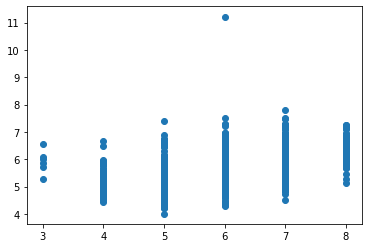

In [49]:
plt.scatter(Y_TEST,pre)#从图上看还是有点离谱

In [50]:
#尝试换个方法


In [52]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=17,n_estimators=200)
forest.fit(X_scaled, Y_TRAIN)
forest.score(X_TEST_scaled,Y_TEST)#真的离谱……

0.5085903215416534

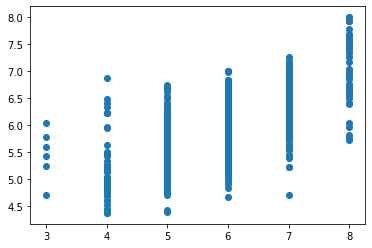

In [53]:
pre2=forest.predict(X_TEST_scaled)
plt.scatter(Y_TEST,pre2)#随机森林看起来半斤八两

In [54]:
#总体还是不行，看看进行SMOTE后的效果

In [55]:
X_TRAIN,X_TEST,Y_TRAIN,Y_TEST=train_test_split(X_smo,Y_smo,test_size=0.3)#用smote后的数据进行分割

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_TRAIN)
X_TEST_scaled = scaler.transform(X_TEST)#标准化
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_scaled.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

    optimizer = tf.compat.v1.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)#用一下earlystop防止过拟合
result=model.fit(X_scaled,Y_TRAIN, epochs=5,validation_split=0.2, verbose=0,callbacks=[early_stop])
model.evaluate(X_TEST_scaled,Y_TEST)

4616/4616 [==============================] - 0s 46us/sample - loss: 0.7618 - mae: 0.6645


[0.7618364106017961, 0.6644965]

In [57]:
#从0.74到0.76，果然不是大数据，神经网络派不上用场，看看随机森林表现

In [58]:
forest = RandomForestRegressor(random_state=17,n_estimators=200)
forest.fit(X_scaled, Y_TRAIN)
forest.score(X_TEST_scaled,Y_TEST)

0.9563909922415345

In [ ]:
#随机森林在smote后就强到离谱……